In [80]:
import scipp as sc
import numpy as np
import matplotlib.pyplot as plt
import plopp as pp
%matplotlib widget
from scipp import curve_fit
from scipy.special import voigt_profile
from functools import partial


In [81]:
## Load and inspect data
#TODO Make a general data loader
## Load actual data - just one temperature for now


Q_STRINGS=['090','110','137','151']
# Q_STRINGS=['151']
Q_values=[0.9,1.1,1.37,1.51]
NUMBER_OF_Q_POINTS=len(Q_STRINGS)
# T_STRINGS=['1.5K', '150K']
T_STRINGS=['1.5K','150K']
T_values=[1.5,150]
NUMBER_OF_T_POINTS=len(T_STRINGS)

#Preallocate
# intensity_values=np.zeros((NUMBER_OF_Q_POINTS,NUMBER_OF_E_POINTS))
# error_values=np.zeros((NUMBER_OF_Q_POINTS,NUMBER_OF_E_POINTS))
Q_index=0
loop_counter=0

for Q_index in range(NUMBER_OF_Q_POINTS):
    for T_index in range(NUMBER_OF_T_POINTS):
        filename = '../../nano/nano_' + T_STRINGS[T_index] +'_6.5a_01.q' +Q_STRINGS[Q_index] 
        # print(filename)

        data_array = np.loadtxt(filename)


    # Define energy, q and intensity as scipp variables with units, and make a DataArraw
        energy=sc.array(dims=['row'],values=data_array[:, 0],unit='meV')
        Q=sc.array(dims=['row'],values=np.ones_like(data_array[:, 0])*Q_values[Q_index],unit='1/angstrom')
        T=sc.array(dims=['row'],values=np.ones_like(data_array[:, 0])*T_values[T_index],unit='K')
        intensity=sc.array(dims=['row'],values=data_array[:, 1],variances=data_array[:, 2]*data_array[:, 2]) #The variance is the square of the uncertainty!
        this_data = sc.DataArray(data=intensity, coords={'energy': energy, 'Q': Q,'T':T})
        if loop_counter==0:
            all_data=this_data  #First time through the loop
        else:       
            all_data=sc.concat([all_data,this_data],dim='row')

        loop_counter+=1

    # this_data.coords['Q']=Q



all_data_grouped=all_data.group('energy','T','Q').bins.mean()
# pp.slicer(all_data_grouped,keep={'energy','Q'})
pp.slicer(all_data_grouped,keep={'energy'},
               linestyle='none',
     marker='o',
     markerfacecolor='none',
     color='k')


Box(children=(InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon…

In [ ]:

sc.show(all_data)

In [82]:
# Unfortunately, it's sometimes necessary to fit the resolution function to the data instead of to vanadium. This happens if the size of the vanadium can is not the same as the sample holder

all_data_grouped=all_data.group('energy','T','Q').bins.mean()
resolution_data=all_data_grouped['T',sc.scalar(1.5,unit='K')].copy(deep=True) #Need to make a copy to allow adding a mask

non_nan_mask=sc.isnan(resolution_data.data)

resolution_data.masks['not_nan']=non_nan_mask
resolution_data

<scipp.DataArray>
Dimensions: Sizes[energy:1245, Q:4, ]
Coordinates:
* Q                         float64           [1/Å]  (Q)  [0.9, 1.1, 1.37, 1.51]
  T                         float64              [K]  ()  1.5
* energy                    float64            [meV]  (energy)  [-10.645, -10.635, ..., 1.335, 1.345]
Data:
                            float64  [dimensionless]  (energy, Q)  [-nan(ind), -nan(ind), ..., -nan(ind), -nan(ind)]  [-nan(ind), -nan(ind), ..., -nan(ind), -nan(ind)]
Masks:
  not_nan                      bool        <no unit>  (energy, Q)  [True, True, ..., True, True]

In [83]:

## 3. Define resolution function and fit vanadium data
# TODO: Make a library of functions instead of defining them inline.
# TODO: Add a Lorentzian tail to the resolution function
def resolution_function_scipp(energy, energy_offset, res_gauss1_area, res_gauss1_sigma, res_BG):
    """
    Calculate the resolution function using the given parameters.

    Parameters:
    energy (array-like): The energy values.
    energy_offset (float): The energy offset.
    res_gauss1_area (float): The area of the first Gaussian component.
    res_gauss1_sigma (float): The standard deviation of the first Gaussian component.
    res_BG (float): The background value.

    Returns:
    array-like: The calculated resolution function values.
    """
    x = energy
    x = x - energy_offset

    y = res_gauss1_area * 1 / np.sqrt(2 * np.pi) / res_gauss1_sigma * sc.exp(-0.5 * (x / res_gauss1_sigma) ** 2) + res_BG
    return y


ENERGY_MIN=-0.4*sc.Unit('meV')
ENERGY_MAX=0.4*sc.Unit('meV')

resolution_data_for_fit=resolution_data['energy',ENERGY_MIN:ENERGY_MAX]
popt_dict = {}
for Q_index in range(NUMBER_OF_Q_POINTS):
    popt, _ = curve_fit(['energy'], resolution_function_scipp, resolution_data_for_fit['Q',sc.scalar(Q_values[Q_index],unit='1/angstrom')], 
                        p0 = {'res_gauss1_area': 75.0*sc.Unit('meV'), 
                            'res_gauss1_sigma': 0.02 * sc.Unit('meV'),
                            'energy_offset'   : 0 * sc.Unit('meV'),
                            'res_BG'          :0.05})
    popt_dict[Q_index] = popt

# There is a bug in the current version of scipp that makes it impossible to fit the data the normal way when using a mask
# popt, _ = curve_fit(['energy'], resolution_function_scipp, resolution_data, 
#                     p0 = {'res_gauss1_area': 5e-1*sc.Unit('meV'), 
#                         'res_gauss1_sigma': 0.2 * sc.Unit('meV'),
#                         'energy_offset'   : 0 * sc.Unit('meV'),
#                         'res_BG'          :0.05})
popt

DataGroup(sizes={}, keys=[
    energy_offset: DataArray({}),
    res_gauss1_sigma: DataArray({}),
    res_gauss1_area: DataArray({}),
    res_BG: DataArray({}),
])

In [84]:

#Calculate the fit to display it
#TODO Make it possible to calculate the fit on a more dense set of points than the data
resolution_fit = None

for Q_index in range(NUMBER_OF_Q_POINTS):
    # Get the popt for the current Q value
    popt = popt_dict[Q_index]

    # Calculate the fit for the current Q value
    fit_result = resolution_function_scipp(resolution_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy'],
                                               energy_offset=sc.values(popt['energy_offset']),
                                               res_gauss1_area=sc.values(popt['res_gauss1_area']),
                                               res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
                                               res_BG=sc.values(popt['res_BG']))
    # print(resolution_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy'])
    # print(fit_result)

    # Set the energy coordinates of the resolution fit to match the current Q value
    fit_result.coords['energy'] = resolution_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy']

    # Concatenate the result with previous results
    if resolution_fit is None:
        resolution_fit = fit_result
    else:
        resolution_fit = sc.concat([resolution_fit, fit_result], dim='Q')

resolution_fit.coords['Q']=resolution_data.coords['Q']
resolution_fit.coords['T']=resolution_data.coords['T']

resolution_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy']
fit_result

<scipp.DataArray>
Dimensions: Sizes[energy:1245, ]
Coordinates:
* energy                    float64            [meV]  (energy)  [-10.645, -10.635, ..., 1.335, 1.345]
Data:
                            float64  [dimensionless]  (energy)  [0.412922, 0.412922, ..., 0.412922, 0.412922]

In [85]:


# Make a group of the data and the fit for the slicer
data_and_fit=sc.DataGroup({'Data': resolution_data,
                            'Fit': resolution_fit})

pp.slicer(data_and_fit,
     keep=['energy'],
     linestyle=         {'Data': 'none',    'Fit': '-'},
     marker=            {'Data': 'o',       'Fit':'none'},
     markerfacecolor=   {'Data': 'none',    'Fit':'red'},
     color=             {'Data': 'black',   'Fit':'red'}
)


Box(children=(InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon…

In [86]:
## 4 Define the fit function and fit the background data

## TODO: The function should include detailed balance
def hem_BG_fit_function_scipp(energy, energy_offset, res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG):
    """
    Elastic plus quasielastic signal with a Gaussian resolution and a constant background

    Parameters:
    energy (array-like): The energy values.
    energy_offset (float): The energy offset.
    res_gauss1_sigma (float): The standard deviation of the Gaussian resolution function.
    el_area (float): The area of the elastic peak.
    lorz1_area (float): The area of the Lorentzian peak.
    lorz1_HWHM (float): The half-width at half-maximum of the Lorentzian peak.
    BG (float): The background value.

    Returns:
    array-like: The calculated GGG fit function values.
    """

    # Subtract energy offset from energy values
    x = energy-energy_offset

    # Calculate elastic peak using resolution function
    y_el = resolution_function_scipp(energy, energy_offset, el_area, res_gauss1_sigma, 0)

    # scipp doesn't allow using some functions like the voigt_profile, imported from scipy. We therefore need to convert the scipp arrays to numpy arrays.
    # TODO Make a scipp version of the voigt_profile
    y_lorz=lorz1_area.value*(voigt_profile(x.values, res_gauss1_sigma.value, lorz1_HWHM.value))

    # Sum elastic and Lorentzian peaks and add background
    y = y_el.values + y_lorz + BG.values

    # Return the result as a scipp array
    y=sc.array(dims=['energy'],values=y,unit='dimensionless')    
    
    return y



# Define the energy range to fit the background
all_data_grouped=all_data.group('energy','T','Q').bins.mean()
background_data=all_data_grouped.copy(deep=True) #Need to make a copy to allow adding a mask
non_nan_mask=sc.isnan(background_data.data)
background_data.masks['not_nan']=non_nan_mask

background_fit = None

ENERGY_MIN=-2*sc.Unit('meV')
ENERGY_MAX=2*sc.Unit('meV')

background_data_for_fit=background_data['energy',ENERGY_MIN:ENERGY_MAX]
background_data_for_fit

<scipp.DataArray>
Dimensions: Sizes[energy:380, T:2, Q:4, ]
Coordinates:
* Q                         float64           [1/Å]  (Q)  [0.9, 1.1, 1.37, 1.51]
* T                         float64              [K]  (T)  [1.5, 150]
* energy                    float64            [meV]  (energy)  [-1.995, -1.985, ..., 1.335, 1.345]
Data:
                            float64  [dimensionless]  (energy, T, Q)  [0.0102747, 0.00275348, ..., 0.428612, -nan(ind)]  [4.74691e-05, 2.42059e-05, ..., 0.0033986, -nan(ind)]
Masks:
  not_nan                      bool        <no unit>  (energy, T, Q)  [False, False, ..., False, True]

In [87]:


background_data_for_fit_single_T=background_data_for_fit['T',sc.scalar(150,unit='K')]
popt_dict_BG = {}
for Q_index in range(NUMBER_OF_Q_POINTS):
    res_gauss1_sigma_fit = popt_dict[Q_index]['res_gauss1_sigma'].value*sc.Unit('meV')

    # TODO problem: need to be able to easily fix parameters
    # hem_fit_function_fixed_resolution_scipp(energy, energy_offset, res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG):
    hem_fit_function_fixed_resolution_scipp = partial(hem_BG_fit_function_scipp, res_gauss1_sigma=res_gauss1_sigma_fit)


    popt_BG, _ = curve_fit(['energy'], hem_fit_function_fixed_resolution_scipp, background_data_for_fit_single_T['Q',sc.scalar(Q_values[Q_index],unit='1/angstrom')], 
    p0 = {'energy_offset': 0 * sc.Unit('meV'),
        'el_area': 75 * sc.Unit('meV'),
        'lorz1_area': 50 * sc.Unit('meV'),
        'lorz1_HWHM': 0.2 * sc.Unit('meV'),
        'BG': 0.05 * sc.Unit('dimensionless')}
    )
    popt_dict_BG[Q_index] = popt_BG


In [88]:

background_fit=None

for Q_index in range(NUMBER_OF_Q_POINTS):
    # Get the popt for the current Q value
    popt = popt_dict_BG[Q_index]

    # Calculate the fit for the current Q value
    fit_result_temp = hem_BG_fit_function_scipp(background_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy'],
                                            energy_offset=sc.values(popt['energy_offset']),
                                            res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
                                            el_area=sc.values(popt['el_area']),
                                            lorz1_area=sc.values(popt['lorz1_area']),
                                            lorz1_HWHM=sc.values(popt['lorz1_HWHM']),
                                            BG=sc.values(popt['BG']))
    fit_result=sc.DataArray(data=fit_result_temp, coords={'energy': background_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy']})



    # Concatenate the result with previous results
    if background_fit is None:
        background_fit = fit_result
    else:
        background_fit = sc.concat([background_fit, fit_result], dim='Q')

background_fit.coords['Q']=background_data.coords['Q']
background_fit.coords['T']=background_data.coords['T']

# background_fit
# fit_result
# fit_result2=sc.DataArray(dims=['energy'],values=fit_result.values,unit='dimensionless')
# this_data = sc.DataArray(data=intensity, coords={'energy': energy, 'Q': Q,'T':T})
# fit_result2



In [89]:
# Make a group of the data and the fit for the slicer
data_and_fit=sc.DataGroup({'Data': background_data_for_fit_single_T,
                            'Fit': background_fit})

pp.slicer(data_and_fit,
     keep=['energy'],
     linestyle=         {'Data': 'none',    'Fit': '-'},
     marker=            {'Data': 'o',       'Fit':'none'},
     markerfacecolor=   {'Data': 'none',    'Fit':'red'},
     color=             {'Data': 'black',   'Fit':'red'}
)


Box(children=(InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon…

In [96]:
## Now fix the background and fit the data. We need to write another fit function



def hem_fit_function_scipp(energy, energy_offset, res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG,DHO1_area,DHO1_pos,DHO1_gamma,DHO2_area,DHO2_pos,DHO2_gamma,lorz2_area,lorz2_HWHM):


    
    BG=hem_BG_fit_function_scipp(energy, energy_offset, res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG)

    x = energy-energy_offset

    DHO1=DHO1_area*2*DHO1_gamma*x**2*DHO1_pos**2/np.pi/((x**2-DHO1_pos**2)**2 +4*DHO1_gamma**2*x**2) #Should include detailed balance, but that's a detail for now
    DHO2=DHO2_area*2*DHO2_gamma*x**2*DHO2_pos**2/np.pi/((x**2-DHO2_pos**2)**2 +4*DHO2_gamma**2*x**2) #Should include detailed balance, but that's a detail for now
    print(x)
    print(DHO1)
    print(DHO2)
    print(DHO1_area)
    print(DHO1_pos)
    print(DHO1_gamma)
    print(DHO1_area*DHO1_gamma*DHO1_pos)
    # xx=np.linspace(-5*res_gauss1_sigma,5*res_gauss1_sigma, num=1001)
    # Gauss_resolution=resolution_function_scipp(xx, 0, 1, res_gauss1_sigma.value, 0)
    # Gauss_resolution=Gauss_resolution/np.sum(Gauss_resolution) #Normalize to 1

    # DHO_convoluted=np.convolve(DHO1.values+DHO2.values,Gauss_resolution.values, 'same')

    DHO_convoluted=DHO1.values+DHO2.values

    Lorz2=lorz2_area.value*(voigt_profile(x.values, res_gauss1_sigma.value, lorz2_HWHM.value))

    y=BG.values+DHO_convoluted+Lorz2

    # Return the result as a scipp array
    y=sc.array(dims=['energy'],values=y,unit='dimensionless')    
    
    return y





<scipp.DataArray>
Dimensions: Sizes[energy:1000, ]
Data:
                            float64  [2.5669699665355694e-44*J^2]  (energy)  [0, 0, ..., 0, 0]


<scipp.DataArray>
Dimensions: Sizes[energy:1000, ]
Data:
                            float64  [2.5669699665355694e-44*J^2]  (energy)  [0.00761134, 0.00764822, ..., 0.00785152, 0.00781309]


<scipp.Variable> ()    float64            [meV]  0
<scipp.Variable> ()    float64            [meV]  0.3
<scipp.Variable> ()    float64            [meV]  0.1
<scipp.Variable> ()    float64  [6.58933480909562217e-88*W*m^6*kg^3/s^5]  0


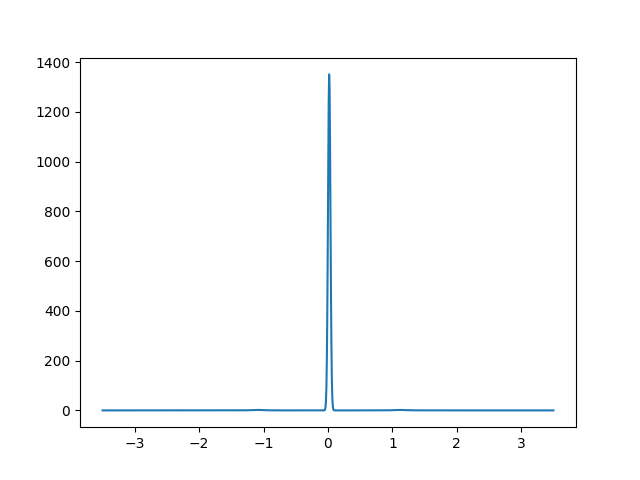

In [97]:
plt.cla()
xx=sc.array(dims=['energy'],values=np.linspace(-3.5,3.5,1000),unit='meV')
y=hem_fit_function_scipp(energy=xx,
energy_offset=sc.values(popt['res_gauss1_sigma']),
res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
el_area=sc.values(popt['el_area']),
lorz1_area=sc.scalar(0,unit='meV'),
lorz1_HWHM=sc.scalar(0.2,unit='meV'),
BG=sc.scalar(0.00,unit='dimensionless'),
DHO1_area=sc.scalar(0.,unit='meV'),
DHO1_pos=sc.scalar(0.3,unit='meV'),
DHO1_gamma=sc.scalar(0.1,unit='meV'),
DHO2_area=sc.scalar(1,unit='meV'),
DHO2_pos=sc.scalar(1.1,unit='meV'),
DHO2_gamma=sc.scalar(0.1,unit='meV'),
lorz2_area=sc.scalar(0,unit='meV'),
lorz2_HWHM=sc.scalar(0.1,unit='meV'))

#plot on a log scale

plt.plot(xx.values,y.values)
plt.show()
# change the y axis to be on a log scale
plt.yscale('log')


                                        #   energy_offset=sc.values(popt['res_gauss1_sigma']),
                                        #     res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
                                        #     el_area=sc.values(popt['el_area']),

In [ ]:


# res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG,DHO1_area,DHO1_pos,DHO1_gamma,DHO2_area,DHO2_pos,DHO2_gamma,lorz2_area,lorz2_HWHM
data_for_fit_single_T=all_data_grouped['T',sc.scalar(150,unit='K')].copy(deep=True) #Need to make a copy to allow adding a mask


non_nan_mask=sc.isnan(data_for_fit_single_T.data)

data_for_fit_single_T.masks['not_nan']=non_nan_mask



signal_start_guess=None

for Q_index in range(NUMBER_OF_Q_POINTS):
    # Get the popt for the current Q value
    popt = popt_dict_BG[Q_index]
                                            # energy_offset=sc.values(popt['energy_offset']),
                                            # res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
                                            # el_area=sc.values(popt['el_area']),
                                            # lorz1_area=sc.values(popt['lorz1_area']),
                                            # lorz1_HWHM=sc.values(popt['lorz1_HWHM']),
                                            # BG=sc.values(popt['BG']),
    # Calculate the fit for the current Q value
    fit_result_temp = hem_fit_function_scipp(data_for_fit_single_T['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy'],
                                             energy_offset=sc.values(popt['res_gauss1_sigma']),
                                            res_gauss1_sigma=sc.values(popt['res_gauss1_sigma']),
                                            el_area=sc.values(popt['el_area']),
                                            lorz1_area=0.0*sc.Unit('meV'),
                                            lorz1_HWHM=0.2*sc.Unit('meV'),
                                            BG=sc.values(popt['BG']),
                                            DHO1_area=0.0*sc.Unit('meV'),
                                            DHO1_pos=0.3*sc.Unit('meV'),
                                            DHO1_gamma=0.1*sc.Unit('meV'),
                                            DHO2_area=5000*sc.Unit('meV'),
                                            DHO2_pos=1.1*sc.Unit('meV'),
                                            DHO2_gamma=0.1*sc.Unit('meV'),
                                            lorz2_area=0*sc.Unit('meV'),
                                            lorz2_HWHM=0.2*sc.Unit('meV'))
    fit_result=sc.DataArray(data=fit_result_temp, coords={'energy': background_data['Q', sc.scalar(Q_values[Q_index], unit='1/angstrom')].coords['energy']})


    # Concatenate the result with previous results
    if signal_start_guess is None:
        signal_start_guess = fit_result
    else:
        signal_start_guess = sc.concat([signal_start_guess, fit_result], dim='Q')

signal_start_guess.coords['Q']=background_data.coords['Q']
signal_start_guess.coords['T']=background_data.coords['T']

data_and_guess=sc.DataGroup({'Data': data_for_fit_single_T,
                            'Guess': signal_start_guess})

pp.slicer(data_and_guess,
     keep=['energy'],
     linestyle=         {'Data': 'none',    'Guess': '-'},
     marker=            {'Data': 'o',       'Guess':'none'},
     markerfacecolor=   {'Data': 'none',    'Guess':'red'},
     color=             {'Data': 'black',   'Guess':'red'}
)


In [ ]:


popt_dict_fit = {}
# for Q_index in range(NUMBER_OF_Q_POINTS):
for Q_index in [3]:
    res_gauss1_sigma_fit = popt_dict_BG[Q_index]['res_gauss1_sigma'].value*sc.Unit('meV')
    el_area_fit=popt_dict_BG[Q_index]['el_area'].value*sc.Unit('meV')
    lorz1_area_fit=popt_dict_BG[Q_index]['lorz1_area'].value*sc.Unit('meV')
    lorz1_HWHM_fit=popt_dict_BG[Q_index]['lorz1_HWHM'].value*sc.Unit('meV')
    BG_fit=popt_dict_BG[Q_index]['BG'].value*sc.Unit('dimensionless')

    # TODO problem: need to be able to easily fix parameters
    # hem_fit_function_fixed_resolution_scipp(energy, energy_offset, res_gauss1_sigma,el_area,lorz1_area,lorz1_HWHM,BG):
    hem_fit_function_fixed_resolution_and_BG_scipp = partial(hem_fit_function_scipp, 
                                                             res_gauss1_sigma=res_gauss1_sigma_fit,
                                                             el_area=el_area_fit,
                                                             lorz1_area=lorz1_area_fit,
                                                             lorz1_HWHM=lorz1_HWHM_fit,
                                                             BG=BG_fit)
    


    popt_signal, _ = curve_fit(['energy'], hem_fit_function_fixed_resolution_and_BG_scipp, data_for_fit_single_T['Q',sc.scalar(Q_values[Q_index],unit='1/angstrom')], 
    p0 = {'energy_offset': 0 * sc.Unit('meV'),
        'DHO1_area': 0.1 * sc.Unit('meV'),
        'DHO1_pos': 0.3 * sc.Unit('meV'),
        'DHO1_gamma': 0.1 * sc.Unit('meV'),
        'DHO2_area': 0.1 * sc.Unit('meV'),
        'DHO2_pos': 1.1 * sc.Unit('meV'),
        'DHO2_gamma': 0.1 * sc.Unit('meV'),
        'lorz2_area': 50 * sc.Unit('meV'),
        'lorz2_HWHM': 0.2 * sc.Unit('meV')}
    )
    popt_dict_fit[Q_index] = popt_signal

popt_BG